In [1]:
#!pip install matplotlib

In [2]:
#!pip install torch torch_geometric

In [3]:
#!pip install scipy

In [4]:
#!pip install scikit-learn

In [ ]:
#!pip install numpy
!pip install seaborn

# Graph Convolutional Neural Networks

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np


In [2]:
dataset = KarateClub()
data = dataset[0]
print(data) 


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [27]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
print(model)


GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [29]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

epochs = 200
for epoch in range(epochs):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 1.4002
Epoch 20, Loss: 0.8985
Epoch 40, Loss: 0.3918
Epoch 60, Loss: 0.1234
Epoch 80, Loss: 0.0475
Epoch 100, Loss: 0.0269
Epoch 120, Loss: 0.0196
Epoch 140, Loss: 0.0161
Epoch 160, Loss: 0.0141
Epoch 180, Loss: 0.0128


In [30]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

y_true = data.y.cpu().numpy()
y_pred = pred.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7647
Precision: 0.8118
Recall: 0.7949
F1-score: 0.7842


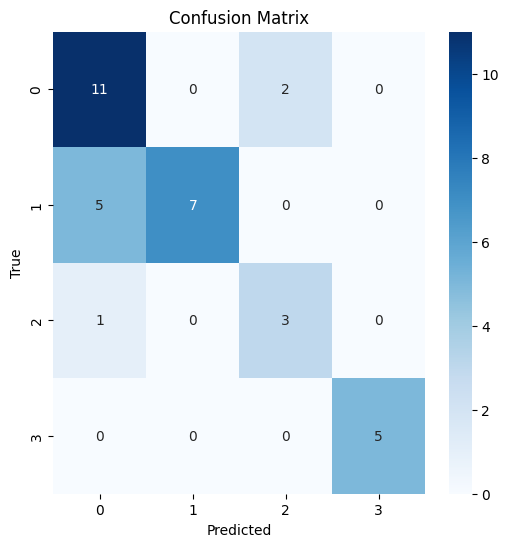

In [31]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


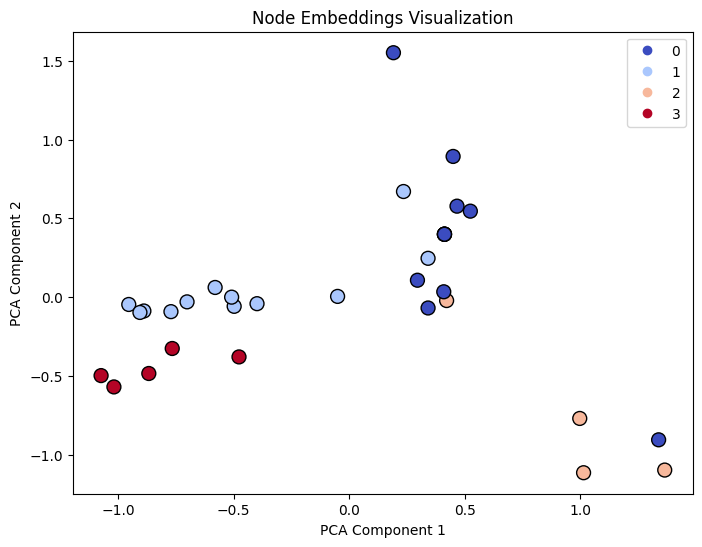

In [42]:
from sklearn.decomposition import PCA

embeddings = model.conv1(data.x, data.edge_index).cpu().detach().numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_true, cmap="coolwarm", edgecolors="k", s=100)
plt.legend(handles=scatter.legend_elements()[0], labels=[str(label) for label in np.unique(y_true)])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Node Embeddings Visualization")
plt.show()


# GraphSAGE

In [34]:
from torch_geometric.nn import SAGEConv

In [35]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
print(model)


GraphSAGE(
  (conv1): SAGEConv(34, 16, aggr=mean)
  (conv2): SAGEConv(16, 4, aggr=mean)
)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [37]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

epochs = 200
for epoch in range(epochs):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 1.4124
Epoch 20, Loss: 0.3404
Epoch 40, Loss: 0.0116
Epoch 60, Loss: 0.0034
Epoch 80, Loss: 0.0029
Epoch 100, Loss: 0.0029
Epoch 120, Loss: 0.0030
Epoch 140, Loss: 0.0029
Epoch 160, Loss: 0.0029
Epoch 180, Loss: 0.0028


In [38]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

y_true = data.y.cpu().numpy()
y_pred = pred.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7941
Precision: 0.7917
Recall: 0.8157
F1-score: 0.7904


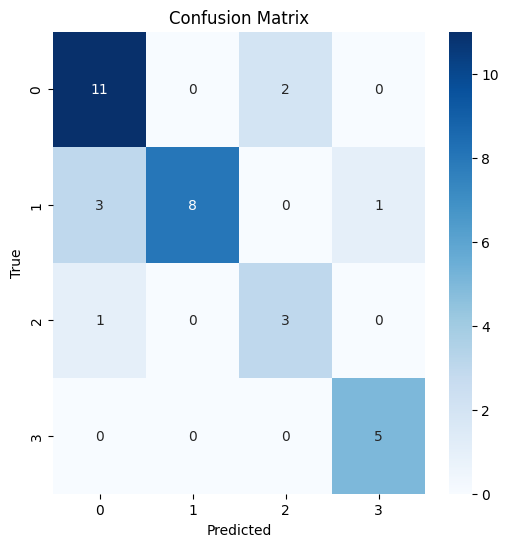

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


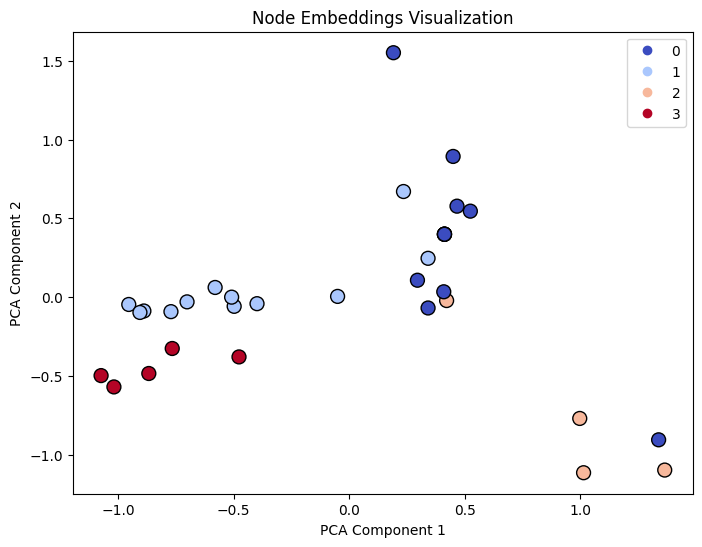

In [41]:
from sklearn.decomposition import PCA

embeddings = model.conv1(data.x, data.edge_index).cpu().detach().numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_true, cmap="coolwarm", edgecolors="k", s=100)
plt.legend(handles=scatter.legend_elements()[0], labels=[str(label) for label in np.unique(y_true)])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Node Embeddings Visualization")
plt.show()


# GAN

In [56]:
from torch_geometric.nn import GATConv


In [57]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)  

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes, heads=2)
print(model)


GAT(
  (conv1): GATConv(34, 16, heads=2)
  (conv2): GATConv(32, 4, heads=1)
)


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [60]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

epochs = 200
for epoch in range(epochs):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 1.4067
Epoch 20, Loss: 0.9790
Epoch 40, Loss: 0.5314
Epoch 60, Loss: 0.2215
Epoch 80, Loss: 0.0858
Epoch 100, Loss: 0.0390
Epoch 120, Loss: 0.0219
Epoch 140, Loss: 0.0146
Epoch 160, Loss: 0.0109
Epoch 180, Loss: 0.0088


In [61]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

y_true = data.y.cpu().numpy()
y_pred = pred.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7941
Precision: 0.8219
Recall: 0.8157
F1-score: 0.8063


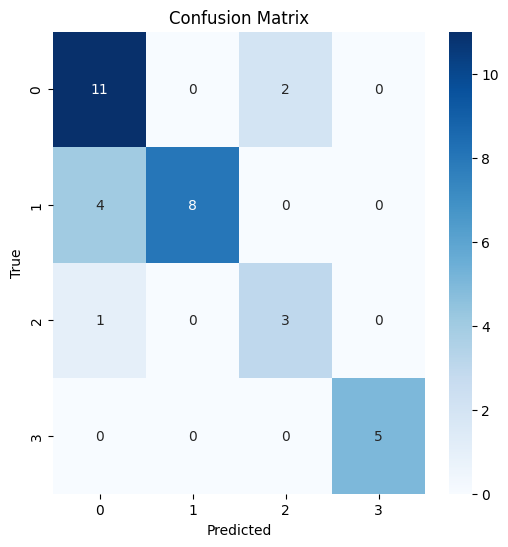

In [62]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


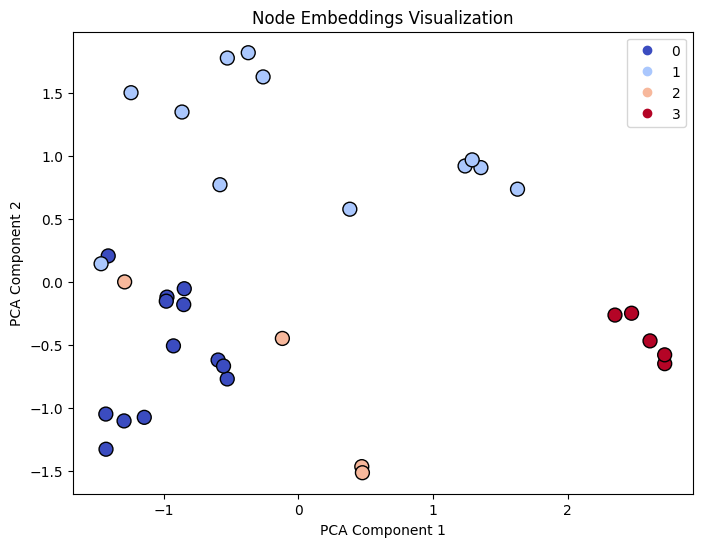

In [63]:
from sklearn.decomposition import PCA

embeddings = model.conv1(data.x, data.edge_index).cpu().detach().numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_true, cmap="coolwarm", edgecolors="k", s=100)

plt.legend(handles=scatter.legend_elements()[0], labels=[str(label) for label in np.unique(y_true)])

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Node Embeddings Visualization")
plt.show()


# Node Embeddings

## Node2Vec

In [ ]:
#!pip install node2vec
#!pip install torch-cluster

  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp38-cp38-macosx_11_0_arm64.whl size=295459 sha256=978d36e2eb4bb31b53c53a1bdbff2a77439dba633df4f37b569b015f38b0af19
  Stored in directory: /Users/jayjao/Library/Caches/pip/wheels/83/ae/16/6e083c8e0651c589dba0257e7d82c6a142ee63cca2f9f41d2d
Successfully built torch-cluster


In [4]:
from torch_geometric.nn import Node2Vec

In [ ]:
node2vec = Node2Vec(data.edge_index, embedding_dim=64, walk_length=20, context_size=10, walks_per_node=10, num_negative_samples=1)
optimizer_n2v = torch.optim.Adam(node2vec.parameters(), lr=0.01)

def train_node2vec():
    node2vec.train()
    optimizer_n2v.zero_grad()
    
    # batch of node indices for training
    batch = torch.randint(0, data.num_nodes, (128,), dtype=torch.long)  # Sample 128 random nodes
    
    # generating positive and negative samples
    pos_rw = node2vec.pos_sample(batch)  # Positive random walks
    neg_rw = node2vec.neg_sample(batch)  # Negative random walks
    
    # the loss
    loss = node2vec.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer_n2v.step()
    
    return loss.item()


epochs_n2v = 100
for epoch in range(epochs_n2v):
    loss = train_node2vec()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Node2Vec Loss: {loss:.4f}")

with torch.no_grad():
    node_embeddings = node2vec().detach()


Epoch 0, Node2Vec Loss: 7.8519
Epoch 10, Node2Vec Loss: 5.9491
Epoch 20, Node2Vec Loss: 4.6647
Epoch 30, Node2Vec Loss: 3.8790
Epoch 40, Node2Vec Loss: 3.3058
Epoch 50, Node2Vec Loss: 2.8850
Epoch 60, Node2Vec Loss: 2.6667
Epoch 70, Node2Vec Loss: 2.5180
Epoch 80, Node2Vec Loss: 2.4075
Epoch 90, Node2Vec Loss: 2.3739


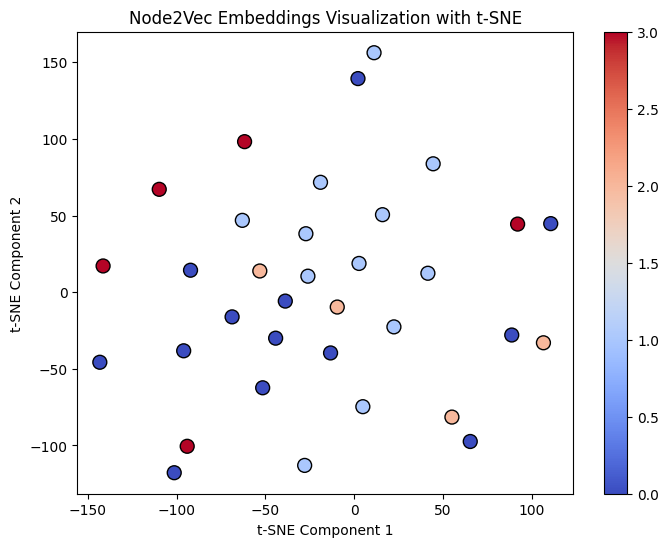

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

with torch.no_grad():
    node_embeddings = node2vec().detach().cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
reduced_embeddings = tsne.fit_transform(node_embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="coolwarm", edgecolors="k", s=100)

plt.colorbar(scatter)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Node2Vec Embeddings Visualization with t-SNE")
plt.show()


# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [10]:
X = data.x.cpu().numpy()  # Node feature matrix
y = data.y.cpu().numpy()  # Labels (class for each node)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.4286
Precision: 0.1071
Recall: 0.2500
F1-score: 0.1500


/opt/anaconda3/envs/beginningGNNs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


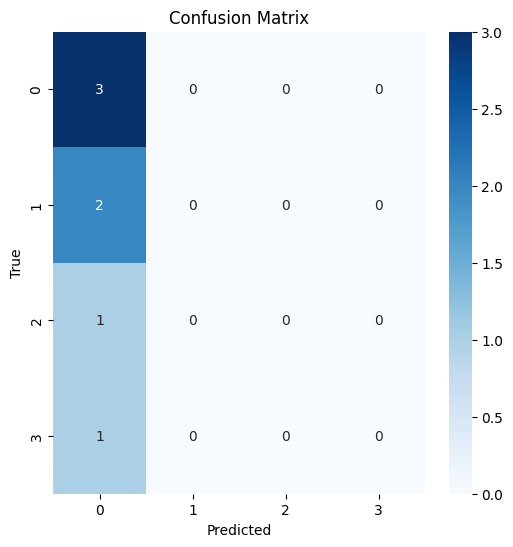

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


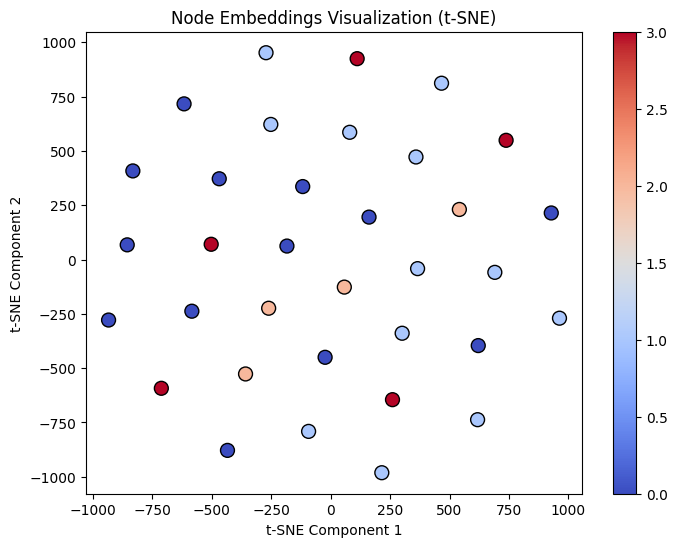

In [17]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X)  # Reduce feature dimensions

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="coolwarm", edgecolors="k", s=100)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Node Embeddings Visualization (t-SNE)")
plt.colorbar()
plt.show()
